# Homework 1: Gradient Descent for Regression

## Handing in
* You are asked to hand in a filled in version of this Jupyter notebook file (you need to complete any "..." and answer all questions). The notebook
should include your theoretical/manually calculated answers as well.
* There will be "assert" commands throughout the notebook, these are meant to ensure that your solution is correct, but don't try to guess the solutions from them because they may be misleading.
* **Late submissions will not be accepted.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

## Assignment

Suppose you are buying a house and you want to know what a good market price would be. One way to do this is to first collect information on recent houses sold and make a model of
housing prices. Below is a selection of the dataset (housing.txt) that came with this exercise:

In [2]:
df = pd.read_csv('housing.txt')
df.head()

,area,bedrooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


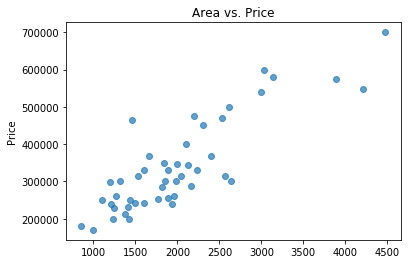

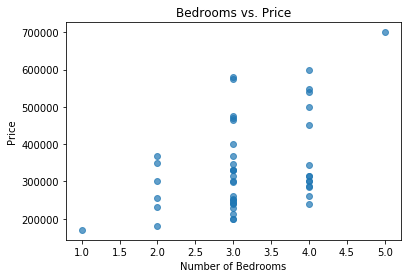

In [3]:
area = df.loc[:,"area"]
bedrooms = df.loc[:,"bedrooms"]
price = df.loc[:,"price"]

plt.figure(0) 
plt.title("Area vs. Price")
plt.ylabel("Price")
plt.scatter(area, price, alpha=0.7)
plt.figure(1) 
plt.title("Bedrooms vs. Price")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Price")
plt.scatter(bedrooms, price, alpha=0.7)

The first column is the area of the house (in square feet), the second column is the number of bedrooms, and the third column is the price of the house.

## A. Feature Normalization

By looking at the values in housing.txt, you will note that house sizes are about 1000 times the number of bedrooms. When features differ by orders of magnitude, first performing feature
scaling can make gradient descent converge much more quickly.

### A.1 Formulas

Given a set of numbers $\{x^{(1)}, \ldots, x^{(M)}\}$ , write down the equations for the mean and standard
deviations of these numbers. The standard deviation is a way of measuring how much variation there is in the range of
values of a particular feature (most data points will lie within 2 standard deviations of the
mean); this is an alternative to taking the range of values (max - min).

Equations for mean and standard deviations:

$
\mu_x = \frac{1}{M} \sum_{i=1}^{M}x_i \\
\sigma_x = \sqrt{\frac{\sum_{i=1}^{M}(x_i-\mu_i)^2}{M}}
$

### A.2 Functions

Write a python function that takes in a list of real numbers and returns the mean and standard deviation for that list.

In [4]:
def mu_sigma(x):
    mu = sum(x)/len(x) #calculating the mean
    
    total_sum = 0
    for i in range(len(x)):
        total_sum += (x[i]-mu)**2 #add the number for stan. dev. to sum
 
    sigma = math.sqrt(total_sum/len(x))
    
    return { 'mean' : mu, 'std' : sigma}

In [5]:
assert mu_sigma([1.2,2.3,3.4,4.5,5.6])['mean'] == 3.4
assert np.round(mu_sigma([1.2,2.3,3.4,4.5,5.6])['std'],2) == 1.56

Write a program that takes as input the dataframe, and creates a file called normalized.bin. To create the normalized variables, subtract the mean value of each feature from the dataset . After subtracting the mean, additionally scale (divide) the feature values by their respective standard deviations.

__Implementation Note:__ 

* When normalizing the features, it is important to store the values used for
normalization - the mean value and the standard deviation used for the computations. After
learning the parameters from the model, we often want to predict the prices of houses we have
not seen before. Given a new x value (living room area and number of bedrooms), we must first
normalize x using the mean and standard deviation that we had previously computed from the
training set. More on this later.
* Sometimes we will choose to not normalize the dependent variable (y), here we opt to normalize it for the sake of simplicity.

In [6]:
import pickle 

def normalize_dataset(df):
    norm_param = []
    
    for col in df:
        norm_param.append((mu_sigma(df[col])['mean'], mu_sigma(df[col])['std']))
        df[col] = ((df[col] - mu_sigma(df[col])['mean']) / mu_sigma(df[col])['std'])
        
    
    #save normalized values to file 
    with open(r"data/normalized.bin", "wb" )  as fh:
        pickle.dump(df,fh)
    
    #save normalized parameters to file 
    with open(r"data/normalized_params.bin", "wb" )  as fh:
        pickle.dump(norm_param,fh)

norm_parameters = normalize_dataset(df)
df.head()


,area,bedrooms,price
0,0.131415,-0.226093,0.480890
1,-0.509641,-0.226093,-0.084983
2,0.507909,-0.226093,0.231097
3,-0.743677,-1.554392,-0.876398
4,1.271071,1.102205,1.612637


## B. Gradient Descent to Find Regression Weights

Our hypothesis (also called the model) will take the form $y=f(x_{1},x_{2})=w_{0}+w_{1}x_{1}+w_{2}x_{2}$ where $x_1$ is the normalized size of the house, $x_2$ is the normalized number of bedrooms, and y is the predicted price of the house. In this problem, your goal is to find the values of $w_0$, $w_1$, and $w_2$ that minimize the mean of the sum of the squared errors (MSE). Read through this whole section (B) before programming.

### B.1 Loss function and gradient

Suppose there are $M$ examples. Write down the formula for the loss function $\mathcal{J}(\boldsymbol{w})$ using the sum of the squared errors. Be sure to include a $\frac{1}{2M}$ term. 

$
\mathcal{J}(\mathbf{w}) = \frac{1}{2M}\sum_{i=1}^{M}(y^{(i)} - (w_{0}+w_{1}x_{1}+w_{2}x_{2}))^2\\
\frac{\partial J(w_0,w_1,w_2)}{\partial w_0} =  \frac{1}{M}\sum_{i=1}^{M}(w_0 + w_1x^{(i)} + w_2x^{(i)} - y^{(i)})\\
\frac{\partial J(w_0,w_1,w_2)}{\partial w_1} = \frac{1}{M}\sum_{i=1}^{M}(w_0 + w_1x^{(i)} + w_2x^{(i)} - y^{(i)})x_1^{(i)}\\
\frac{\partial J(w_0,w_2,w_2)}{\partial w_2} = \frac{1}{M}\sum_{i=1}^{M}(w_0 + w_1x^{(i)} + w_2x^{(i)} - y^{(i)})x_2^{(i)}\\
$


### B.2 Implementation

Create a function to calculate the gradient for the loss function as found in Step B.1 (taking into account all terms, including the bias $w_0$).

__Implementation note__: 

* create your function so that it will work for any dimension of w. For instance, if you have 50 variables and 1000 observations, it should work for vectors of size $\mathbf X: 1000 \times 50$,  $\mathbf y : 1000 \times 1$, $\mathbf w: 50 \times 1$

* At all times, check the shapes of your matrices and vectors. 

* Try to avoid for loops at all cost. 

* You can use numpy to calculate dot products (np.dot(x)) and vector sums (np.sum(x)).

* When doing operations (+,-,*,/) on a matrix/vector pair in numpy, take into account that numpy has peculiar rules in terms of output depending on the sizes of the inputs. You can find more about broadcasting [here](http://www.scipy-lectures.org/intro/numpy/operations.html#broadcasting)

In [7]:
def calc_gradient(y,X,w):
    
    #Checks to make sure vectors are of the same size
    assert X.shape[0] == y.shape[0]
    assert X.shape[1] == w.shape[0]
    assert y.shape[1] == w.shape[1] == 1
    
    y_est = X.dot(w).flatten() #flatten returns a 1-D copy of the original matrix
    error = y.flatten() - y_est
    gradient = -(1.0/len(X)) * error.dot(X)
    
    return {'gradient': gradient.T,'loss': (1.0/len(X))*np.sum(np.power(error, 2))}


### B.3 Gradient Descent

Load the normalized dataset and split it in two parts:
* X : A (47,3) shaped np.matrix containing a bias vector (all ones), then area, and then #bedrooms
* y : A (47,1) shaped np.matrix containing the price

__Implementation Note:__ You can use np.ones() and np.hstack to add the bias term to the X

In [8]:
with open(r"data/normalized.bin", "rb") as fh:
    df = pickle.load(fh)
    
#assert not(type(mss) is None), "Wasn't able to load the file..."
bias_vector = np.ones((47,))
area = df.loc[: , "area"]
bedrooms = df.loc[: , "bedrooms"]
price = df.loc[: , "price"]

new_df = np.column_stack((bias_vector, area.values, bedrooms.values))

X = np.matrix(new_df)
y = np.matrix(price).T

In [9]:
assert y.shape == (47,1)
assert (len(np.where(X[0,:] == 399900)[0]) == 0),"You shouldn't have the price variable in your X matrix."             
assert X.shape == (47,3),"Did you add the bias term?"
assert (X[0,0] == 1),"The first column of X should contain the bias term (a column of all ones)."

Implement gradient descent to find the values $w_{0}$ ,$w_{1}$, and $w_{2}$ that minimize $\mathcal{J}(\boldsymbol{w})$. Apply your code to the normalized data set using the learning rates $\alpha=[1.3,0.1,0.05,0.01]$ and a total of 25 passes through the dataset.

In [10]:
def gradient_descent(y,X,w,num_iterations,alpha,show_detailed):
        iteration = 1
        error_vals = []
        
        print("\n- Alpha value: " + str(alpha) + " -\n")
        
        while iteration <= num_iterations:

            #Get the gradient at each step
            result = calc_gradient(y, X, w)
            gradient = result['gradient']
            error = result['loss']
            
            #Adjust weights based on gradient & learning rate
            new_w = w - alpha * gradient
            
            #Print status at specified intervals
            if iteration % 5 == 0:
                if show_detailed:
                    print("iter: %d, bias: %.4f, area: %.4f, bed: %.4f, err: %.4f" %(iteration, new_w[0], new_w[1], new_w[2], np.sum(error)))
                else:
                    print("iter: %d, err: %.4f" %(iteration, np.sum(error)))
            iteration += 1
            w = new_w
            
            #Each time we iterate we take the sum of the error and append it
            error_vals.append(np.sum(error))

        # Now that we've kept track of the error at each alpha & iteration we can measure performance
        err = np.array(error_vals)
        return err, w
        
alpha_count = 0
alphas = [1.3,.10,0.05,0.01]
num_iterations = 25

alpha_err = np.zeros((num_iterations,len(alphas)))
w_random = np.zeros((X.shape[1],1))

for alpha in alphas:
    err, w = gradient_descent(y,X,w_random,num_iterations,alpha,False)
    alpha_err[:, alpha_count] = err
    alpha_count += 1


- Alpha value: 1.3 -

iter: 5, err: 0.9398
iter: 10, err: 1.1531
iter: 15, err: 1.4344
iter: 20, err: 1.8051
iter: 25, err: 2.2934

- Alpha value: 0.1 -

iter: 5, err: 0.5410
iter: 10, err: 0.3786
iter: 15, err: 0.3266
iter: 20, err: 0.3029
iter: 25, err: 0.2895

- Alpha value: 0.05 -

iter: 5, err: 0.7107
iter: 10, err: 0.5218
iter: 15, err: 0.4264
iter: 20, err: 0.3748
iter: 25, err: 0.3445

- Alpha value: 0.01 -

iter: 5, err: 0.9295
iter: 10, err: 0.8523
iter: 15, err: 0.7854
iter: 20, err: 0.7275
iter: 25, err: 0.6773


 A good way to verify that gradient descent is working correctly is to look at the value of $\mathcal{J}(\boldsymbol{w})$ and check that it is decreasing with each step. Assuming you have implemented gradient descent correctly and your learning rate is not too big, your value of $\mathcal{J}(\boldsymbol{w})$ should never increase, and should converge to a steady value by the end of the algorithm. 
    
Plot $\mathcal{J}(\boldsymbol{w})$ for 25 iterations for each of your $\alpha$ values. 

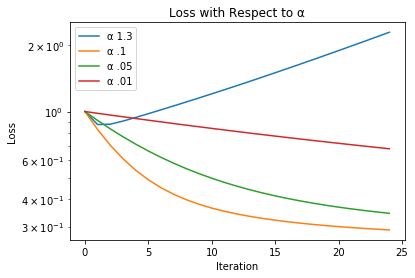

In [11]:
plt.semilogy(alpha_err[:, 0], label='\u03B1 1.3');
plt.semilogy(alpha_err[:, 1], label='\u03B1 .1');
plt.semilogy(alpha_err[:, 2], label='\u03B1 .05');
plt.semilogy(alpha_err[:, 3], label='\u03B1 .01');
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss with Respect to \u03B1")
plt.legend();

**Describe the figure and reflect on your findings:**

### Alpha values
I found this exercise particularly useful in understanding the importance of tuning hyperparameters to yield the best performance:

$ \alpha  = 1.3: $
As expected, the first alpha value of 1.3 overshoots the minimum and continues to increase, never converging. 

$ \alpha  = .01: $ 
The alpha value of .01 took too long and never converged since the steps while calculating the gradient were too small

$ \alpha  = .05, .1: $
The alpha values of .05 and .1 yielded the best performance and found convergence
 

### Considerations
As specified in the assignment we are asked to calculate the gradient/loss for 25 iterations at four seperate alpha values. However, I imagine that a more empirical way to find the best alpha this is to assign a threshold of convergence and break the loop once the algorithm reaches that threshold (and of course a ceiling if it never converges). Then, after testing a series of different alpha values, the value that offers the fastest convergence serves as the best alpha for that scenario. 

## C. Predicting House Prices

You will now use your best estimate of $\boldsymbol{w}$, obtained in the previous part to predict the housing prices. Predict the price of a house with 1650 square feet and 3 bedrooms. 

**Implementation Notes:** Don't forget to normalize your features when you make this prediction! 

In [12]:
def normalize_val(val, n_params):
    n_area = (val - n_params[0][0]) / n_params[0][1]
    n_bedrooms = (val - n_params[1][0]) / n_params[1][1]
    n_price = (val - n_params[2][0]) / n_params[2][1]
    return{'area': n_area, 'bedrooms': n_bedrooms, 'price': n_price }

def denormalize_val(val, n_params):
    n_area = (val * n_params[0][1]) + n_params[0][0]
    n_bedrooms = (val * n_params[1][1]) + n_params[1][0]
    n_price = (val * n_params[2][1]) + n_params[2][0]
    
    return{'area': n_area, 'bedrooms': n_bedrooms, 'price': n_price }

with open(r"data/normalized_params.bin", "rb") as fh:
    n_params = pickle.load(fh)

pred_X = np.array([1,normalize_val(1650, n_params)["area"], normalize_val(3, n_params)["bedrooms"]])

w_zeros = np.zeros((X.shape[1],1))
err, w = gradient_descent(y,X,w_zeros,25,.1,False)

final_weights = np.array([w.item(0), w.item(1), w.item(2)])

#print(final_weights)

price = denormalize_val(np.sum(final_weights * pred_X), n_params)['price']

print("Predicted price USD $%.2f" % price)


- Alpha value: 0.1 -

iter: 5, err: 0.5410
iter: 10, err: 0.3786
iter: 15, err: 0.3266
iter: 20, err: 0.3029
iter: 25, err: 0.2895
Predicted price USD $297722.05


## D. Stochastic Gradient Descent

Using a learning rate of $\alpha=0.05$ to find the values $w_{0}$ ,$w_{1}$ , and $w_{2}$ using stochastic gradient descent (SGD). Make ten passes through the data set, and provide $\mathcal{J}(\boldsymbol{w})$ after each pass. Randomly shuffle the data set after each pass. 

1. Plot the evolution of the loss and compare it to the plot you made before in B.3
2. How does $\mathcal{J}(\boldsymbol{w})$ compare to the one you obtained in Section B? Why?
3. Also comment on the computation time of the two approaches. 

__Implementation Notes:__
* When adding random elements to your algorithms, it is useful to set the random seed (np.random.seed(123)) to ensure consistency for debugging.
* In question D.2, you are asked to plot after each update as opposed to after each epoch.

Epoch: 1 - Error: 0.2914
Epoch: 2 - Error: 0.2748
Epoch: 3 - Error: 0.2721
Epoch: 4 - Error: 0.2790
Epoch: 5 - Error: 0.2754
Epoch: 6 - Error: 0.2674
Epoch: 7 - Error: 0.2809
Epoch: 8 - Error: 0.2759
Epoch: 9 - Error: 0.2703


Text(0,0.5,'Loss')

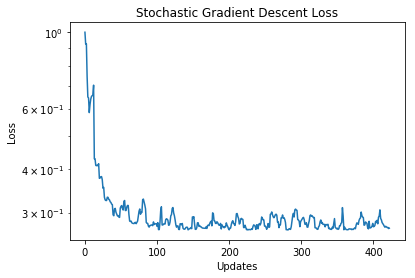

In [13]:
def stochastic_gd(y,X,w,num_epochs,alpha):

    epoch = 1
    decay = 0.95
    error_vals = []
    
    while epoch < num_epochs:
        np.random.seed(123)
        rand_index = np.random.permutation(len(X))
        X = X[rand_index]
        y = y[rand_index]
        b = 0
        
        while b < len(X):
            tX = X[b : b + 1]
            ty = y[b : b + 1]
            
            res = calc_gradient(ty, tX, w)
            gradient = res['gradient']
            
            res_2 = calc_gradient(y, X, w)
            error = res_2['loss']
            
            w -= alpha * gradient
            b += 1
            error_vals.append(np.sum(error))

        if epoch % 1 == 0:
            res_2 = calc_gradient(y, X, w)
            error = res_2["loss"]
            print("Epoch: %d - Error: %.4f" %(epoch, np.sum(error)))

        epoch += 1
        alpha = alpha * (decay ** int(epoch/1000))
    
    err = np.array(error_vals) 
    return err, w


alpha = .05
num_epochs = 10

w_random = np.zeros((X.shape[1],1))

err, w = stochastic_gd(y,X,w_random,num_epochs,alpha)

plt.semilogy(err);
plt.title("Stochastic Gradient Descent Loss")
plt.xlabel("Updates")
plt.ylabel("Loss")

### Comparing Loss

As we might have expected, the loss evolution is far more sporatic than the original gradient descent, but finds convergence equally as fast. During each epoch we randomly shuffle our features dataset and then take the gradient at each point rather than over the whole dataset. This is particularly effective for complex functions since it will find the global minimum faster and is less susceptible to converging to a local minimum. However, since the model is relatively simple, this tradeoff doesnt really come in to play. 

### Speed

SGD is best suited to take advantage of large datasets, however, since this dataset is so small the benefit of speed is difficult to observe. If anything, SGD takes longer to compute since it calculates the gradient more frequently, resulting in a longer runtime. 